# Challenge 3: Artifical Neural Networks

<a target="_blank" href="https://colab.research.google.com/github/LucaPennella/Intro_to_ML_23-24/blob/main/challenges/challenge-three.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


Using Fully Connected Neural Networks and Convolutional Neural Networks, perform the following tasks on [this data set](https://pytorch.org/vision/stable/generated/torchvision.datasets.KMNIST.html#torchvision.datasets.KMNIST).
1. Data exploration.
2. For each architecture, tune the number of the hidden layers ($\le 3$), the optimizer, and some hyperparameters of your choice. How many tries to do is up to your discretion.
3. Summarise your results in a table and comment on them in the report.
4. For a model (not necessarily the best performing one), plot training loss vs testing loss and training accuracy vs testing accuracy, and comment on what you see.

In [4]:
import torch

In [6]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load KMNIST training dataset
train_dataset = datasets.KMNIST(root='./data', train=True, download=True, transform=transform)

# Load KMNIST test dataset
test_dataset = datasets.KMNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Example: Get a batch of data
images, labels = next(iter(train_loader))
print(f'Batch shape: {images.shape}, Labels: {labels[:10]}')


100%|██████████| 18.2M/18.2M [00:26<00:00, 686kB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 133kB/s]
100%|██████████| 3.04M/3.04M [00:04<00:00, 680kB/s]
100%|██████████| 5.12k/5.12k [00:00<00:00, 10.4MB/s]

Batch shape: torch.Size([64, 1, 28, 28]), Labels: tensor([0, 4, 7, 8, 5, 4, 0, 6, 5, 8])


In [8]:
from torch.utils.data import random_split

full_train_dataset = train_dataset
# Define split sizes (e.g. 90% train, 10% val)
train_size = int(0.9 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

# Split the dataset
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

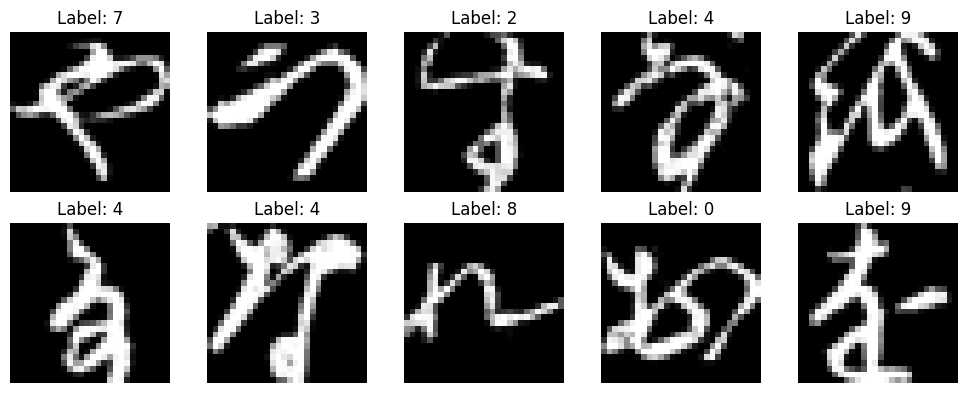

In [25]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 5, figsize=(10, 4))
head = [train_dataset[i] for i in range (10)]
images = [h[0] for h in head]
labels = [h[1] for h in head]
for i, ax in enumerate(axes.flat):
  img = images[i].squeeze(0)
  ax.imshow(img, cmap='gray')
  ax.set_title(f"Label: {labels[i]}")
  ax.axis('off')
plt.tight_layout()
plt.show()

In [26]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [27]:
import torch.nn as nn
import torch.optim as optim

### FULLY CONNECTED ARCHITECTURE

In [28]:
class FCNN(nn.Module):
    def __init__(self):
        super(FCNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.fc(x)

### CONVOLUTIONAL ARCHITECTURE


In [43]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 14x14

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 7x7

            nn.Conv2d(32, 64, kernel_size=3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2) # 4 x 4
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 3 * 3, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        return self.fc_layers(x)


### TRAINING CYCLE

In [34]:
def train(model, train_loader, validation_loader, optimizer, criterion):
    model.train()
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        #total_loss += loss.item()
        #total_correct += (output.argmax(1) == y).sum().item()

    total_loss, total_correct = 0, 0
    # WE USE THE METRICS IN THE VALIDATION
    for x, y in validation_loader:
        x, y = x.to(device), y.to(device)
        output = model(x)
        loss = criterion(output, y)
        total_loss += loss.item()
        total_correct += (output.argmax(1) == y).sum().item()

    acc = total_correct / len(validation_loader.dataset)

    return total_loss / len(validation_loader), acc


In [37]:
### MODEL TEST

def model_test(model, test_loader, criterion):

  total_loss, total_correct = 0, 0
  for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        output = model(x)
        loss = criterion(output, y)
        total_loss += loss.item()
        total_correct += (output.argmax(1) == y).sum().item()

  acc = total_correct / len(test_loader.dataset)

  return total_loss / len(test_loader), acc

In [44]:
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

for epoch in range(5):
    validation_loss, validation_acc = train(model, train_loader, val_loader, optimizer, criterion)
    print(f"Epoch {epoch+1} ON THE VALIDATION - Loss: {validation_loss:.4f}, Accuracy: {validation_acc*100:.2f}%")
test_loss, test_acc = model_test(model, test_loader, criterion)
print(f"TEST SET - Loss: {test_loss:.4f}, Accuracy: {test_acc*100:.2f}%")

Epoch 1 ON THE VALIDATION - Loss: 0.1094, Accuracy: 95.24%
Epoch 2 ON THE VALIDATION - Loss: 0.0430, Accuracy: 97.17%
Epoch 3 ON THE VALIDATION - Loss: 0.0104, Accuracy: 97.33%
Epoch 4 ON THE VALIDATION - Loss: 0.0872, Accuracy: 97.85%
Epoch 5 ON THE VALIDATION - Loss: 0.0874, Accuracy: 97.57%
TEST SET - Loss: 0.2237, Accuracy: 94.42%


In [45]:
model = FCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

for epoch in range(5):
    validation_loss, validation_acc = train(model, train_loader, val_loader, optimizer, criterion)
    print(f"Epoch {epoch+1} ON THE VALIDATION - Loss: {validation_loss:.4f}, Accuracy: {validation_acc*100:.2f}%")
test_loss, test_acc = model_test(model, test_loader, criterion)
print(f"TEST SET - Loss: {test_loss:.4f}, Accuracy: {test_acc*100:.2f}%")

Epoch 1 ON THE VALIDATION - Loss: 0.1181, Accuracy: 90.15%
Epoch 2 ON THE VALIDATION - Loss: 0.0769, Accuracy: 92.65%
Epoch 3 ON THE VALIDATION - Loss: 0.1238, Accuracy: 94.26%
Epoch 4 ON THE VALIDATION - Loss: 0.4588, Accuracy: 93.89%
Epoch 5 ON THE VALIDATION - Loss: 0.0421, Accuracy: 94.19%
TEST SET - Loss: 0.5125, Accuracy: 86.75%
